In [7]:
import sys
sys.path.append('../')  # Go up one level from 'notebooks' to 'lppls'

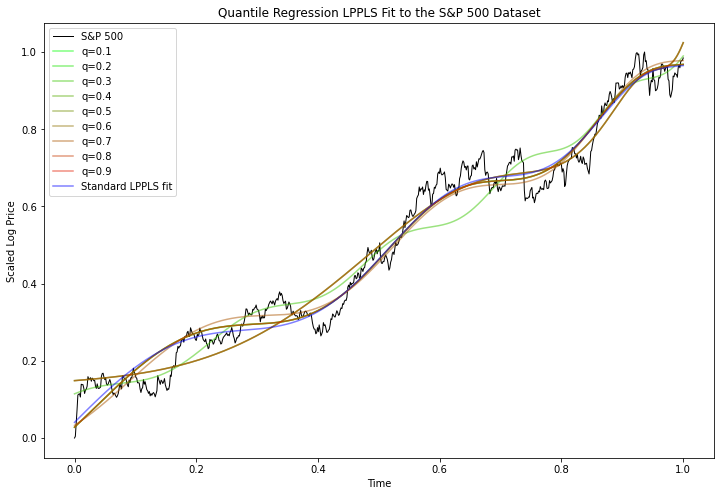

In [18]:
from lppls import lppls, lppls_q
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime as dt
from matplotlib import pyplot as plt
import os

FILE_NAME = 'sp500.csv'

# fetch data if we haven't already
if not os.path.exists(FILE_NAME):
    ticker_symbol = "^GSPC"  # S&P 500
    start_date = "1984-07-30"  # start date from the paper
    end_date = "1987-06-12"   # end date from the paper

    data = yf.download(ticker_symbol, start=start_date, end=end_date)
    data.to_csv(FILE_NAME, index=False)
else:
    data = pd.read_csv(FILE_NAME)


time = data.index
time = (time - time.min()) / (time.max() - time.min())  # scale to [0, 1]

price = np.log(data['Adj Close'].values)
price = (price - price.min()) / (price.max() - price.min())  # scale to [0, 1]

observations = np.array([time, price])

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.figure(figsize=(12, 8))
plt.plot(time, price, label='S&P 500', color='black', linewidth=1)

# plot the quantile fits
for i, q in enumerate(quantiles):

    # instantiate a new QLPPLS model with the specified quantile
    qlppls_model = lppls_q.QLPPLS(observations=observations, q=q)

    # fit the model to the data and get back the params
    tc, m, w, a, b, c, c1, c2, O, D = qlppls_model.fit(25)

    # generate predictions up to t2
    predictions = [qlppls_model.lppls(t, tc, m, w, a, b, c1, c2) for t in time]

    # color from green to red
    color = (i / len(quantiles), 1 - i / len(quantiles), 0)

    # plot the fit
    plt.plot(time, predictions, label=f'q={q}', color=color, alpha=0.5)

# plot standard fit
lppls_model = lppls.LPPLS(observations=observations)
tc, m, w, a, b, c, c1, c2, O, D = lppls_model.fit(25) 
predictions = [lppls_model.lppls(t, tc, m, w, a, b, c1, c2) for t in time]
plt.plot(time, predictions, label=f'Standard LPPLS fit', color='blue', alpha=0.5)

# show plot
plt.title('Quantile Regression LPPLS Fit to the S&P 500 Dataset')
plt.xlabel('Time')
plt.ylabel('Scaled Log Price')
plt.legend()
plt.show()